In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import optuna.integration.lightgbm as lgb
import xgboost as xgb
import pickle
import os

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Helper functions

In [2]:
def get_float_cols(df:DataFrame):
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame):
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame):
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame):
    return list(df.select_dtypes(include=object).columns)

In [3]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['SalePrice']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

In [4]:
def get_correlation_matrix(df:DataFrame):
    
    path_name = 'corr_matrix.pickle'
    if os.path.exists(path_name) == False:
        corr_matrix = df.corr()
        pickle.dump(corr_matrix, open(path_name, 'wb'))
    else:
        corr_matrix = pickle.load(open(path_name, 'rb'))
    
    return corr_matrix

In [5]:
def remove_aggr_function(str_to_check:str) -> str:
    parts = str_to_check.split('_')
    if (len(parts) > 4):
        index_to_remove = len(parts) - 2
        parts.remove(parts[index_to_remove])
        result = '_'.join(parts)
        return result
    else:
        return str_to_check

In [6]:
def load_churn_data():
    
    with open('churn_model.pcl', 'rb') as file:
        deserialized_object = pickle.load(file)
        
    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]
    
    train_df['abon_id'] = train_df['abon_id'].astype('Int64')
    train_num['abon_id'] = train_num['abon_id'].astype('Int64')
    train_dpi['abon_id'] = train_dpi['abon_id'].astype('Int64')
    
    test_df['abon_id'] = test_df['abon_id'].astype('Int64')
    test_num['abon_id'] = test_num['abon_id'].astype('Int64')
    test_dpi['abon_id'] = test_dpi['abon_id'].astype('Int64')
    
    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [7]:
def get_heatmap_matrix(df:DataFrame):
    corr_matrix = get_correlation_matrix(df)
    heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
    heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
    heatmap_matrix = heatmap_matrix.drop(index=['target'])
    heatmap_matrix = heatmap_matrix[heatmap_matrix['target'] > 0.05]
    return heatmap_matrix

In [8]:
def plot_heatmap(df:DataFrame):
    heatmap_matrix = get_heatmap_matrix(df)
    plt.figure(figsize=(40, 120))
    heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);
    return heatmap_matrix

In [9]:
def get_important_features(df:DataFrame):
    heatmap_matrix = get_heatmap_matrix(df)
    df_features = heatmap_matrix.reset_index()
    df_features = df_features.rename(columns = {'index':'feature'})
    df_features['feature_group'] = df_features['feature'].apply(remove_aggr_function)
    df_features = df_features[['feature', 'feature_group', 'target']]
    sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
    important_features = sorted_features.groupby('feature_group').first()
    return important_features

## Verify short numbers

In [10]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_data()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

In [11]:
len(train_df[train_df['target'] == 1]), len(train_df[train_df['target'] == 0])

(9586, 140414)

## Correlation matrix

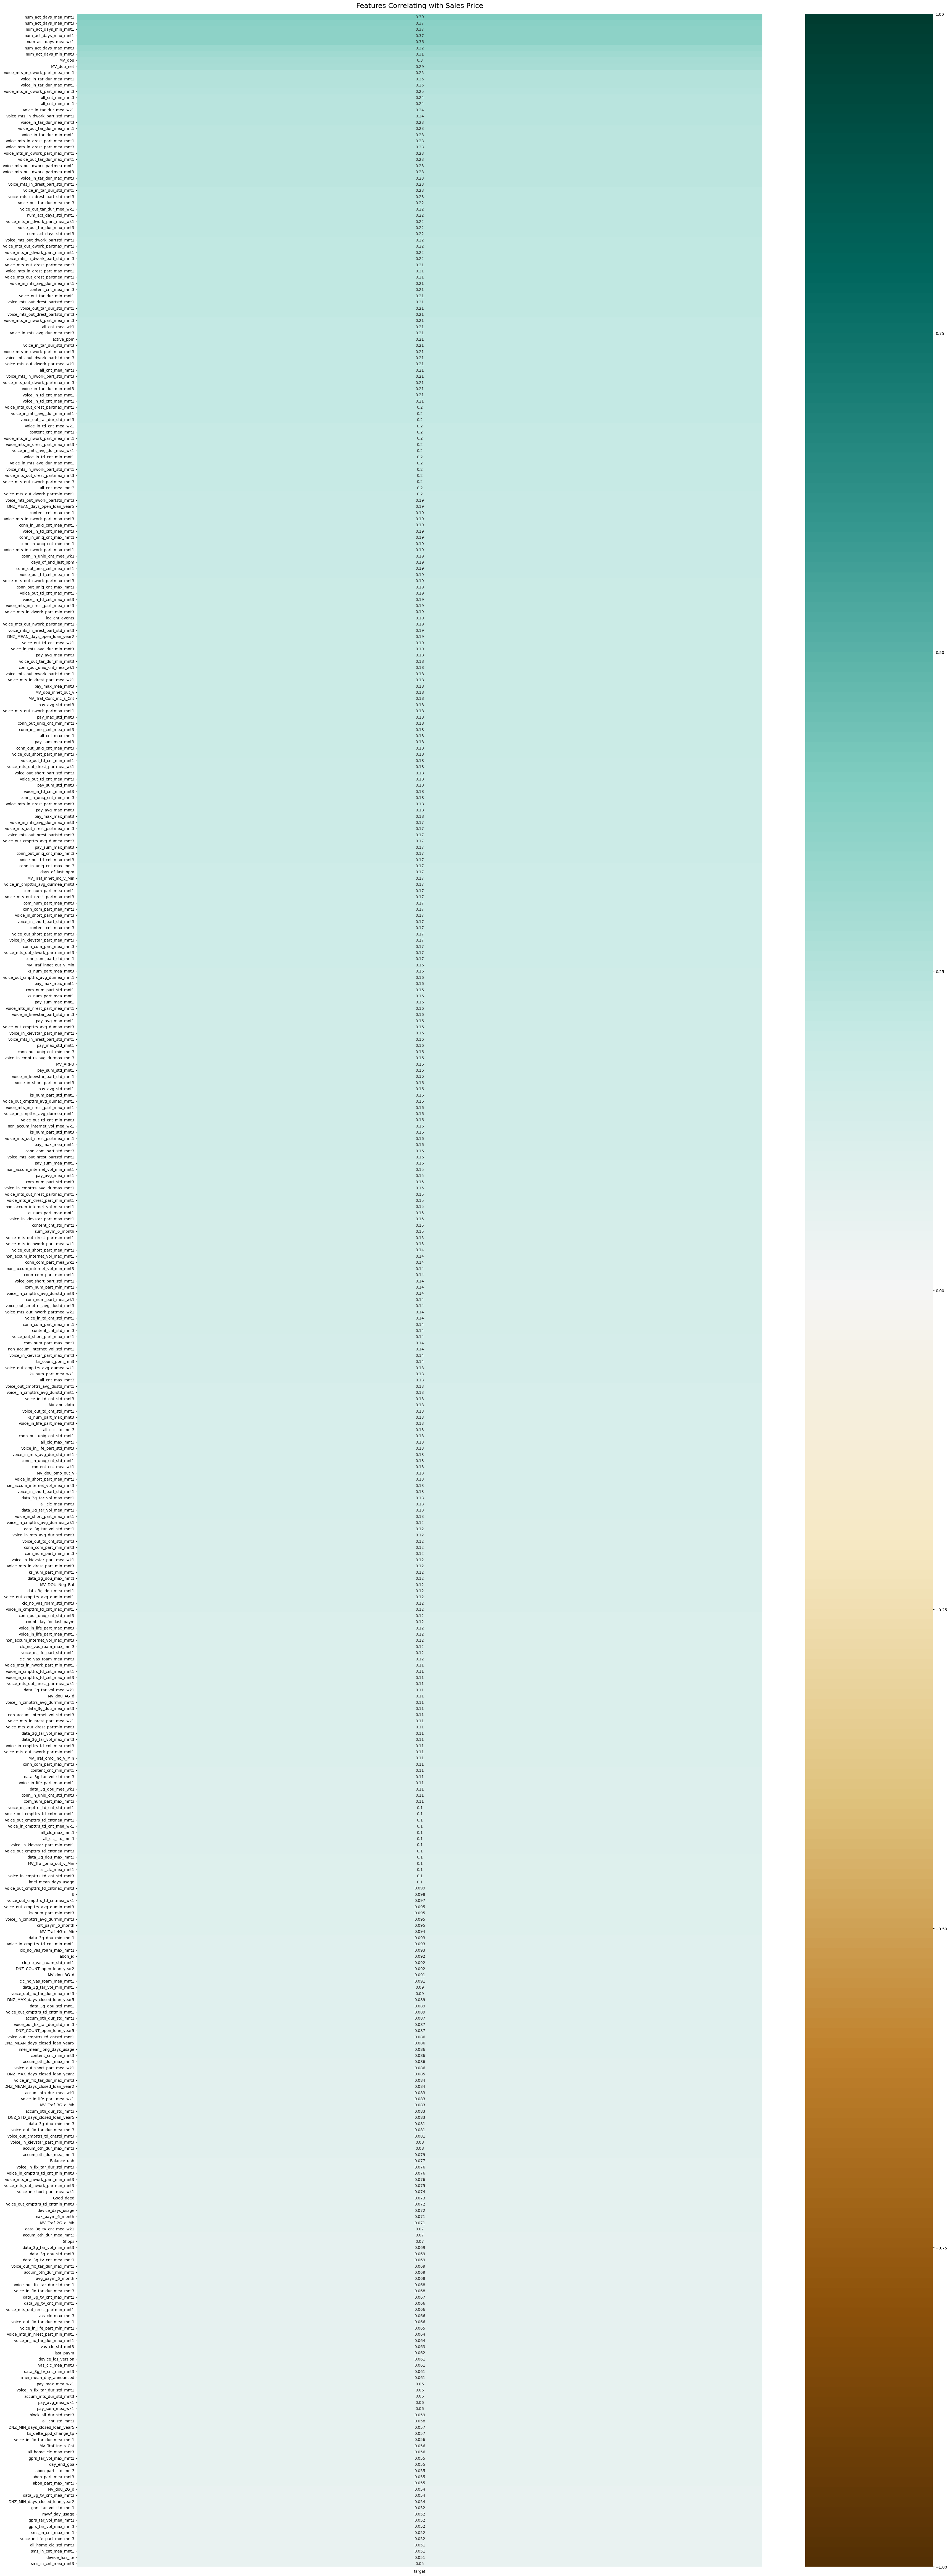

In [12]:
heatmap_matrix = plot_heatmap(df_combine)

In [17]:
important_features = get_important_features(df_combine)


['feature', 'target']

In [19]:
important_features['feature']

feature_group
Balance_uah                                     Balance_uah
DNZ_COUNT_open_year2              DNZ_COUNT_open_loan_year2
DNZ_COUNT_open_year5              DNZ_COUNT_open_loan_year5
DNZ_MAX_days_closed_year2    DNZ_MAX_days_closed_loan_year2
DNZ_MAX_days_closed_year5    DNZ_MAX_days_closed_loan_year5
                                          ...              
voice_out_tar_dur_mnt3           voice_out_tar_dur_mea_mnt3
voice_out_tar_dur_wk1             voice_out_tar_dur_mea_wk1
voice_out_td_cnt_mnt1             voice_out_td_cnt_mea_mnt1
voice_out_td_cnt_mnt3             voice_out_td_cnt_mea_mnt3
voice_out_td_cnt_wk1               voice_out_td_cnt_mea_wk1
Name: feature, Length: 214, dtype: object

feature_group
Balance_uah                  0.077437
DNZ_COUNT_open_year2         0.092005
DNZ_COUNT_open_year5         0.086824
DNZ_MAX_days_closed_year2    0.085486
DNZ_MAX_days_closed_year5    0.088910
                               ...   
voice_out_tar_dur_mnt3       0.224994
voice_out_tar_dur_wk1        0.224486
voice_out_td_cnt_mnt1        0.188353
voice_out_td_cnt_mnt3        0.178373
voice_out_td_cnt_wk1         0.185119
Name: target, Length: 214, dtype: float64

## Telephone Feature

In [14]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

(set(churned_numbers) - set(non_churned_numbers))

{b'0578',
 b'10200',
 b'1107',
 b'20035',
 b'2552',
 b'3103',
 b'3113',
 b'3600',
 b'380442270911',
 b'380442286369',
 b'380442370372',
 b'380442371358',
 b'380442790962',
 b'380444558887',
 b'380444562043',
 b'380444565002',
 b'380444635745',
 b'380444865271',
 b'380444961496',
 b'380445013009',
 b'380445022010',
 b'380445155023',
 b'380445276910',
 b'380445278653',
 b'380445278742',
 b'380445317877',
 b'380445663427',
 b'380445668384',
 b'380445949780',
 b'380459551126',
 b'380459561534',
 b'380487051800',
 b'380487058720',
 b'380487294741',
 b'380487374528',
 b'380487525698',
 b'380487777880',
 b'380487946239',
 b'380500506296',
 b'380501036600',
 b'380502230311',
 b'380502915474',
 b'380503009050',
 b'380503320440',
 b'380503423348',
 b'380503649060',
 b'380503747737',
 b'380503870100',
 b'380503889890',
 b'380503909383',
 b'380504004648',
 b'380504030594',
 b'380504194944',
 b'380504237872',
 b'380504431615',
 b'380504632838',
 b'380504634187',
 b'380504634252',
 b'380504650877',


## Groupping

In [15]:
gr = train_num.groupby(['abon_id'])
gr.groups

{1545052: [0, 1], 1545235: [2, 3, 4, 5, 6, 7], 1549591: [8], 1558772: [9, 10, 11], 1558921: [12, 13, 14], 1560464: [15, 16, 17, 18, 19, 20, 21, 22, 23], 1574321: [24, 25, 26, 27, 28], 1580281: [29, 30, 31], 1581064: [32, 33, 34, 35], 1582506: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], 1582902: [47, 48, 49, 50, 51], 1585461: [52, 53, 54, 55], 1586369: [56, 57, 58, 59, 60, 61], 1608877: [62, 63, 64, 65, 66, 67], 1610598: [68, 69, 70, 71, 72, 73, 74], 1610707: [75, 76, 77, 78, 79, 80, 81, 82, 83], 1611069: [84, 85, 86, 87], 1611112: [88, 89, 90], 1611873: [91, 92, 93], 1612053: [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110], 1613378: [111, 112, 113, 114, 115, 116, 117, 118], 1615091: [119, 120, 121, 122], 1616231: [123, 124, 125, 126, 127, 128], 1617311: [129, 130, 131, 132, 133, 134, 135, 136], 1617378: [137, 138, 139, 140, 141, 142, 143], 1618917: [144, 145, 146, 147], 1619052: [148, 149, 150], 1619507: [151, 152, 153, 154, 155, 156, 157, 158, 159], 1

In [16]:
# cor_matrix = train_df.corr()